# Homework 10 - CIFAR10 Image Classification with PyTorch

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [0]:
import torch
torch.rand(5, 3)

tensor([[0.1704, 0.0847, 0.1817],
        [0.8969, 0.9047, 0.7559],
        [0.0716, 0.1528, 0.7472],
        [0.0340, 0.8298, 0.8449],
        [0.6746, 0.7327, 0.4504]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [0]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [0]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [0]:
!mkdir hw10_data

In [0]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data/', download=True, train=False, transform=transformations)

0it [00:00, ?it/s]

 99%|█████████▉| 169500672/170498071 [00:12<00:00, 13168614.81it/s]

Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [0]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004275, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.926468, Train Accuracy: 0.325750
  Epoch 0 @ step 2000: Train Loss: 1.820062, Train Accuracy: 0.346500
  Epoch 0 @ step 3000: Train Loss: 1.785277, Train Accuracy: 0.361625
  Epoch 0 @ step 4000: Train Loss: 1.765938, Train Accuracy: 0.366125
  Epoch 0 @ step 5000: Train Loss: 1.770911, Train Accuracy: 0.374500
  Epoch 0 @ step 6000: Train Loss: 1.751399, Train Accuracy: 0.369500
Epoch 0 Test Loss: 1.686041, Test Accuracy: 0.396500, time: 17.1s
  Epoch 1 @ step 7000: Train Loss: 1.742550, Train Accuracy: 0.375625
  Epoch 1 @ step 8000: Train Loss: 1.739604, Train Accuracy: 0.378125
  Epoch 1 @ step 9000: Train Loss: 1.744400, Train Accuracy: 0.374625
  Epoch 1 @ step 10000: Train Loss: 1.731967, Train Accuracy: 0.381875
  Epoch 1 @ step 11000: Train Loss: 1.761922, Train Accuracy: 0.370000
  Epoch 1 @ step 12000: Train Loss: 1.758104, Train Accuracy: 0.367000
Epoch 1 Test Loss: 1.719

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

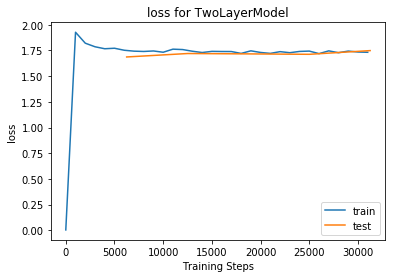

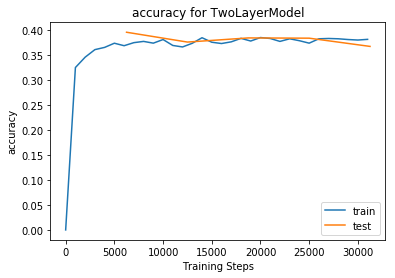

In [0]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [0]:
class ConvModel(nn.Module):
  # Your Code Here
  def __init__(self):
    super(ConvModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(4096, 64), 
        nn.ReLU(), 
        nn.Linear(64, 10))
    
  def forward(self, x):
    return self.conv(x)

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004307, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.835803, Train Accuracy: 0.337250
  Epoch 0 @ step 2000: Train Loss: 1.592801, Train Accuracy: 0.417500
  Epoch 0 @ step 3000: Train Loss: 1.494804, Train Accuracy: 0.456625
  Epoch 0 @ step 4000: Train Loss: 1.447257, Train Accuracy: 0.481875
  Epoch 0 @ step 5000: Train Loss: 1.433165, Train Accuracy: 0.482000
  Epoch 0 @ step 6000: Train Loss: 1.410358, Train Accuracy: 0.486000
Epoch 0 Test Loss: 1.462240, Test Accuracy: 0.464400, time: 24.5s
  Epoch 1 @ step 7000: Train Loss: 1.398430, Train Accuracy: 0.498500
  Epoch 1 @ step 8000: Train Loss: 1.357032, Train Accuracy: 0.508250
  Epoch 1 @ step 9000: Train Loss: 1.361926, Train Accuracy: 0.508250
  Epoch 1 @ step 10000: Train Loss: 1.354716, Train Accuracy: 0.518875
  Epoch 1 @ step 11000: Train Loss: 1.343928, Train Accuracy: 0.514250
  Epoch 1 @ step 12000: Train Loss: 1.317494, Train Accuracy: 0.526500
Epoch 1 Test Loss: 1.268

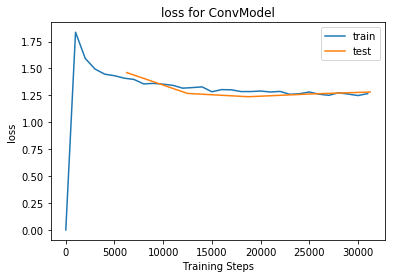

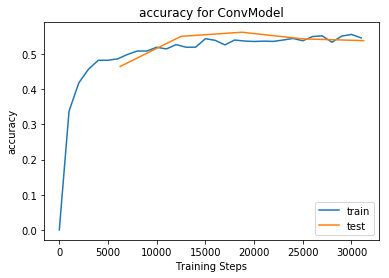

In [0]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

Yes.

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [0]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
# You Awesome Super Best model code here
class AwesomeModel(nn.Module):
  # Your Code Here
  def __init__(self):
    super(AwesomeModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Dropout(p=0.2),
        
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Dropout(p=0.3),
        
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Dropout(p=0.4),
        
        Flatten(),
        nn.Linear(1024, 100), 
        nn.ReLU(),
        nn.Linear(100, 10))
    
  def forward(self, x):
    return self.conv(x)

In [0]:
## Load Saved Model
# PATH = 'drive/My Drive/CS 498 AML/HW10/model2_checkpoint_3Conv2D_3.pth.tar'
# model = AwesomeModel()
# model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
# model.to(device)

# Initialize Model
model = AwesomeModel().to(device)

# Training
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics = train(model, train_loader, test_loader, loss, optimizer, 60)
# torch.save(model.state_dict(), 'drive/My Drive/CS 498 AML/HW10/model2_checkpoint_3Conv2D_5.pth.tar')

  Epoch 0 @ step 0: Train Loss: 0.004334, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.713327, Train Accuracy: 0.369750
  Epoch 0 @ step 2000: Train Loss: 1.406628, Train Accuracy: 0.498375
  Epoch 0 @ step 3000: Train Loss: 1.259663, Train Accuracy: 0.546500
  Epoch 0 @ step 4000: Train Loss: 1.168738, Train Accuracy: 0.583750
  Epoch 0 @ step 5000: Train Loss: 1.091209, Train Accuracy: 0.613125
  Epoch 0 @ step 6000: Train Loss: 1.026775, Train Accuracy: 0.633375
Epoch 0 Test Loss: 0.899229, Test Accuracy: 0.685400, time: 53.2s
  Epoch 1 @ step 7000: Train Loss: 0.984515, Train Accuracy: 0.655375
  Epoch 1 @ step 8000: Train Loss: 0.958142, Train Accuracy: 0.662750
  Epoch 1 @ step 9000: Train Loss: 0.917372, Train Accuracy: 0.680375
  Epoch 1 @ step 10000: Train Loss: 0.899818, Train Accuracy: 0.689375
  Epoch 1 @ step 11000: Train Loss: 0.860245, Train Accuracy: 0.699250
  Epoch 1 @ step 12000: Train Loss: 0.861270, Train Accuracy: 0.700250
Epoch 1 Test Loss: 0.774

**What changes did you make to improve your model?**

We used BatchNorm2d after each Conv2d layer to normalize data. After two Conv2d-ReLU-BatchNorm2d series, MaxPool2d was added to extract significant information from convolutional data followed by a Dropout layer to decrease overfitting. The whole process was repeated two more times before Flatten() and 2 fully-connected Linear layers. We trained for 60 epochs to ensure maximum test accuracy. However, it seems like the model started overfitting and test accuracy stopped increasing just after 50,000 steps. The optimizer was also changed to Adam optimizer due to its general effectiveness in reducing loss in computer vision applications. We also experimented on adding another set of convolutional layers and Linear layer, but these approaches did not improve the test accuracy.

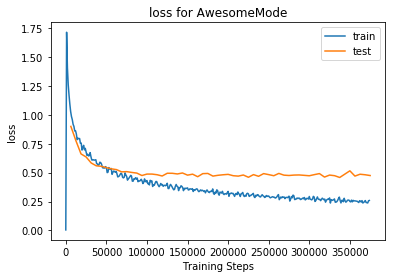

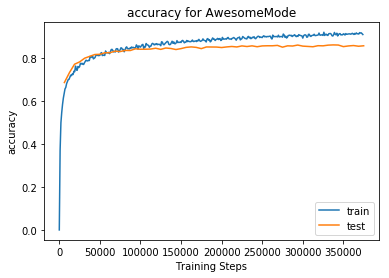

In [0]:
plot_graphs("AwesomeMode", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [0]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-28 02:03:41--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-28 02:03:41--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip’

test_file.zip       100%[===================>]   3.66M  5.69MB/s    in 0.6s    

2019-04-28 02:03:42 (5.69 MB/s) - ‘test_file.zip’ saved [3841776/3841776]

Archive:  test_file.zip
  inflating: test_file.pt            


Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
import torch.utils.data as Data

test_file = 'test_file.pt'

tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor)  
test_loader = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)
all_lab = []
for ele in test_loader:
    x = ele[0] 
    x = x.view(-1,3,32,32)
    model.eval()
    with torch.no_grad():
      x = x.to(device)
      output = model(x)
      ind = torch.argmax(output, dim=1)
      lab = ind.cpu().numpy()
      all_lab.append(lab)
all_lab = np.array(all_lab)
all_lab = all_lab.flatten()
np.savetxt('drive/My Drive/CS 498 AML/HW10/submission.txt', all_lab, fmt='%d', delimiter=',', newline='\n')